In [74]:
pip install missingno  

Note: you may need to restart the kernel to use updated packages.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

# Any results you write to the current directory are saved as output.

In [2]:
## Import Trainning data. 
train = pd.read_csv("train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
## Import test data.
test = pd.read_csv("test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

missing_percentage(train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageCond,81,5.55
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


In [5]:
## trainsforming target variable using numpy.log1p, 
train["SalePrice"] = np.log1p(train["SalePrice"])


In [6]:
## Dropping the "Id" from train and test set. 
# train.drop(columns=['Id'],axis=1, inplace=True)

train.drop(columns=['Id'],axis=1, inplace=True)
test.drop(columns=['Id'],axis=1, inplace=True)

## Saving the target values in "y_train". 
y = train['SalePrice'].reset_index(drop=True)



# getting a copy of train
previous_train = train.copy()

In [7]:
## Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train, test)).reset_index(drop = True)
## Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [8]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [9]:
## In the following features the null values are there for a purpose, so we replace them with "0"
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)
    
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [10]:
## the "OverallCond" and "OverallQual" of the house. 
# all_data['OverallCond'] = all_data['OverallCond'].astype(str) 
# all_data['OverallQual'] = all_data['OverallQual'].astype(str)

## Zoning class are given in numerical; therefore converted to categorical variables. 
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

## Important years and months that should be categorical variables not numerical. 
# all_data['YearBuilt'] = all_data['YearBuilt'].astype(str)
# all_data['YearRemodAdd'] = all_data['YearRemodAdd'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 

In [11]:
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 

In [12]:
missing_percentage(all_data)

,Total,Percent


In [13]:
# feture engineering a new feature "TotalFS"
all_data['TotalSF'] = (all_data['TotalBsmtSF'] 
                       + all_data['1stFlrSF'] 
                       + all_data['2ndFlrSF'])

all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] 
                                 + all_data['BsmtFinSF2'] 
                                 + all_data['1stFlrSF'] 
                                 + all_data['2ndFlrSF']
                                )
                                 

all_data['Total_Bathrooms'] = (all_data['FullBath'] 
                               + (0.5 * all_data['HalfBath']) 
                               + all_data['BsmtFullBath'] 
                               + (0.5 * all_data['BsmtHalfBath'])
                              )
                               

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] 
                              + all_data['3SsnPorch'] 
                              + all_data['EnclosedPorch'] 
                              + all_data['ScreenPorch'] 
                              + all_data['WoodDeckSF']
                             )
                              
                              


In [14]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [15]:
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

In [16]:
## Creating dummy variable 
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2919, 334)

In [17]:
X = final_features.iloc[:len(y), :]

X_sub = final_features.iloc[len(y):, :]

In [18]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [19]:
counts = X.BsmtUnfSF.value_counts()

In [20]:
counts.iloc[0]

117

In [21]:
for i in X.columns:
    counts = X[i].value_counts()
    print (counts)

60.0     142
70.0      70
80.0      69
50.0      56
75.0      53
        ... 
33.0       1
152.0      1
149.0      1
140.0      1
141.0      1
Name: LotFrontage, Length: 132, dtype: int64
7200     25
9600     24
6000     17
10800    14
8400     14
         ..
7406      1
9453      1
9450      1
15593     1
13300     1
Name: LotArea, Length: 1069, dtype: int64
5     396
6     374
7     318
8     167
4     115
9      43
3      19
10     18
2       3
1       2
Name: OverallQual, dtype: int64
5    818
6    252
7    205
8     72
4     56
3     25
9     22
2      4
1      1
Name: OverallCond, dtype: int64
2006    66
2005    64
2004    54
2007    49
2003    45
        ..
1906     1
1911     1
1913     1
1917     1
1872     1
Name: YearBuilt, Length: 112, dtype: int64
1950    177
2006     96
2007     76
2005     73
2004     62
       ... 
1982      6
1983      5
1952      5
1986      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64
0.0      865
72.0       8
180.0      8
120.0      7


In [22]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(X)

X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [23]:
X.shape,y.shape, X_sub.shape

((1455, 333), (1455,), (1459, 333))

In [24]:
## Train test s
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((974, 333), (974,), (481, 333), (481,))

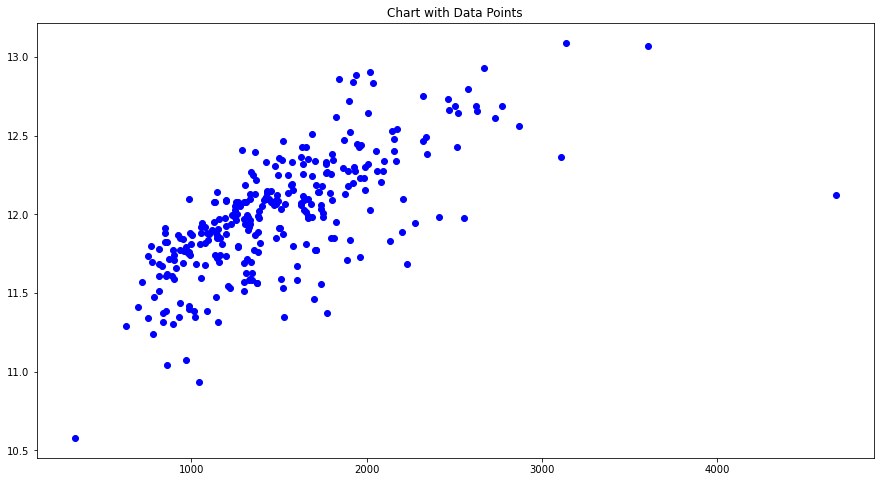

In [26]:
sample_train = previous_train.sample(300)
import seaborn as sns
plt.subplots(figsize = (15,8))
ax = plt.gca()
ax.scatter(sample_train.GrLivArea.values, sample_train.SalePrice.values, color ='b');
plt.title("Chart with Data Points");
#ax = sns.regplot(sample_train.GrLivArea.values, sample_train.SalePrice.values)
#ax.plot((sample_train.GrLivArea.values.min(),sample_train.GrLivArea.values.max()), (sample_train.SalePrice.values.mean(),sample_train.SalePrice.values.mean()), color = 'r');

In [27]:
## Calculating Mean Squared Error(MSE)
sample_train['mean_sale_price'] = sample_train.SalePrice.mean()
sample_train['mse'] = np.square(sample_train.mean_sale_price - sample_train.SalePrice)
sample_train.mse.mean()
## getting mse
print("Mean Squared Error(MSE) for average line is : {}".format(sample_train.mse.mean()))

Mean Squared Error(MSE) for average line is : 0.14303707522244868


In [28]:
## Calculating the beta coefficients by hand. 
## mean of y. 
y_bar = sample_train.SalePrice.mean()
## mean of x. 
x_bar = sample_train.GrLivArea.mean()
## Std of y
std_y = sample_train.SalePrice.std()
## std of x
std_x = sample_train.GrLivArea.std()
## correlation of x and y
r_xy = sample_train.corr().loc['GrLivArea','SalePrice']
## finding beta_1
beta_1 = r_xy*(std_y/std_x)
## finding beta_0
beta_0 = y_bar - beta_1*x_bar

In [29]:
## getting y_hat, which is the predicted y values. 
sample_train['Linear_Yhat'] = beta_0 + beta_1*sample_train['GrLivArea']

In [31]:
from sklearn.metrics import mean_squared_error
mean_squared_error(sample_train['SalePrice'], sample_train.Linear_Yhat)

0.07442051287195324

In [32]:
## importing necessary models.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
## fit train and test data. 
lin_reg.fit(X_train, y_train)
## Predict test data. 
y_pred = lin_reg.predict(X_test)
## get average squared error(MSE) by comparing predicted values with real values. 
print ('%.2f'%mean_squared_error(y_test, y_pred))

13601085867292847243264.00


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, X,y,cv = cv, scoring = 'neg_mean_absolute_error')
print ('%.8f'%scores.mean())

-0.08870219


In [114]:
# ## Importing Ridge. 
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# ## Assiging different sets of alpha values to explore which can be the best fit for the model. 
# alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
# temp_rss = {}
# temp_mse = {}
# for i in alpha_ridge:
#     ## Assigin each model. 
#     ridge = Ridge(alpha= i, normalize=True)
#     ## fit the model. 
#     ridge.fit(X_train, y_train)
#     ## Predicting the target value based on "Test_x"
#     y_pred = ridge.predict(X_test)

#     mse = mean_squared_error(y_test, y_pred)
#     rss = sum((y_pred-y_test)**2)
#     temp_mse[i] = mse
#     temp_rss[i] = rss

In [48]:
from sklearn.linear_model import Lasso 
temp_rss = {}
temp_mse = {}
alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
for i in alpha_ridge:
    ## Assigin each model. 
    lasso_reg = Lasso(alpha= i, normalize=True)
    ## fit the model. 
    lasso_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    y_pred = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rss = sum((y_pred-y_test)**2)
    temp_mse[i] = mse
    temp_rss[i] = rss

In [116]:
# from sklearn.linear_model import ElasticNet
# temp_rss = {}
# temp_mse = {}
# for i in alpha_ridge:
#     ## Assigin each model. 
#     lasso_reg = ElasticNet(alpha= i, normalize=True)
#     ## fit the model. 
#     lasso_reg.fit(X_train, y_train)
#     ## Predicting the target value based on "Test_x"
#     y_pred = lasso_reg.predict(X_test)

#     mse = mean_squared_error(y_test, y_pred)
#     rss = sum((y_pred-y_test)**2)
#     temp_mse[i] = mse
#     temp_rss[i] = rss

In [49]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [50]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, 
                                              alphas=alphas2, 
                                              random_state=42, 
                                              cv=kfolds))
# elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [51]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

In [52]:
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

In [53]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [55]:
stack_gen = StackingCVRegressor(regressors=(lasso, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [56]:
# score = cv_rmse(ridge)
# print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(elasticnet)
# print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(svr)
# print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(gbr)
# print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

LASSO: 0.1289 (0.0586)
 2020-12-02 11:07:17.364234
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[Lig

In [57]:
print('START Fit')

# print('stack_gen')
# stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

# print('elasticnet')
# elastic_model_full_data = elasticnet.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso.fit(X, y)

# print('Ridge') 
# ridge_model_full_data = ridge.fit(X, y)

# print('Svr')
# svr_model_full_data = svr.fit(X, y)

# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
Lasso
xgboost
[11:13:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[11:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
lightgbm
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [63]:
1.0 * xgb_model_full_data.predict(X)

array([12.23289  , 12.083002 , 12.279981 , ..., 12.484016 , 11.8587   ,
       11.9121685], dtype=float32)

In [76]:
def blend_models_predict(X):
    return (
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X))))

In [78]:
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
9.02448594737912


In [132]:
print('Predict submission')
submission = pd.read_csv("sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

Predict submission


In [133]:
q1 = submission['SalePrice'].quantile(0.005)
q2 = submission['SalePrice'].quantile(0.995)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
submission.to_csv("submission.csv", index=False)

In [ ]:
(0.1 * elastic_model_full_data.predict(X)) + \

In [ ]:
(0.2 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
#             (0.1 * gbr_model_full_data.predict(X)) + \
(0.3 * stack_gen_model.predict(np.array(X))